In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


In [11]:
p_market = pd.read_csv("data/primogem_market.csv")

<Axes: xlabel='Primogem Supplied', ylabel='Count'>

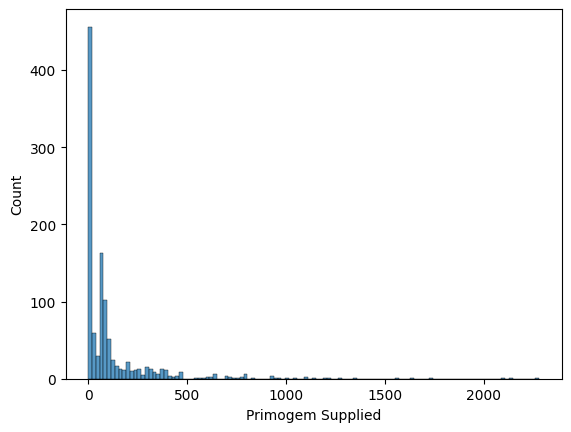

In [12]:
sns.histplot(p_market['Primogem Supplied'])

In [13]:
CUTOFF_C = 50

p_market["Date"]= pd.to_datetime(p_market["Date"])

# Add 600 primogems if 1st or 16th of the monthx
p_market['Primogem Supplied'] = p_market['Primogem Supplied'] + np.where(
    p_market['Date'].dt.day.isin([1, 16]), 
    600, 
    0
)


p_market['primogem_used'] = p_market['Primogem Used'] 
p_market.drop(columns="Primogem Used",inplace = True)

p_market['centered_supplied'] = p_market['Primogem Supplied'] - CUTOFF_C
p_market['supply_spike'] = np.where(p_market['Primogem Supplied']>CUTOFF_C,1,0)




<Axes: xlabel='Date', ylabel='primogem_used'>

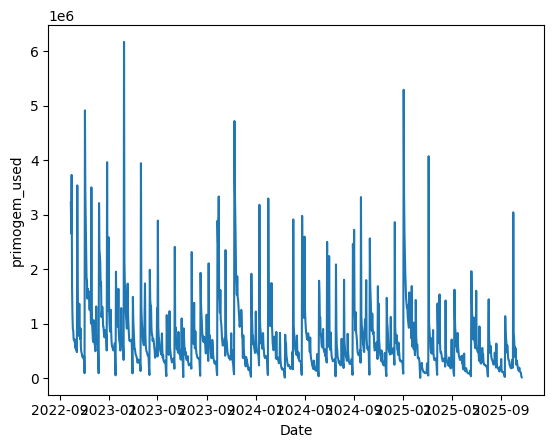

In [14]:
sns.lineplot(data=p_market,x ="Date",y="primogem_used")


<Axes: xlabel='Date', ylabel='Primogem Supplied'>

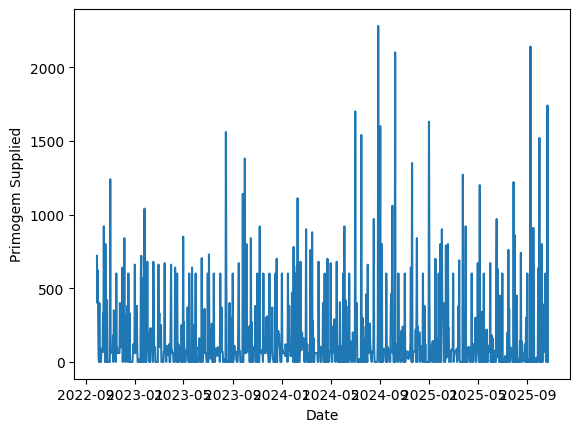

In [15]:
sns.lineplot(data=p_market,x ="Date",y="Primogem Supplied")

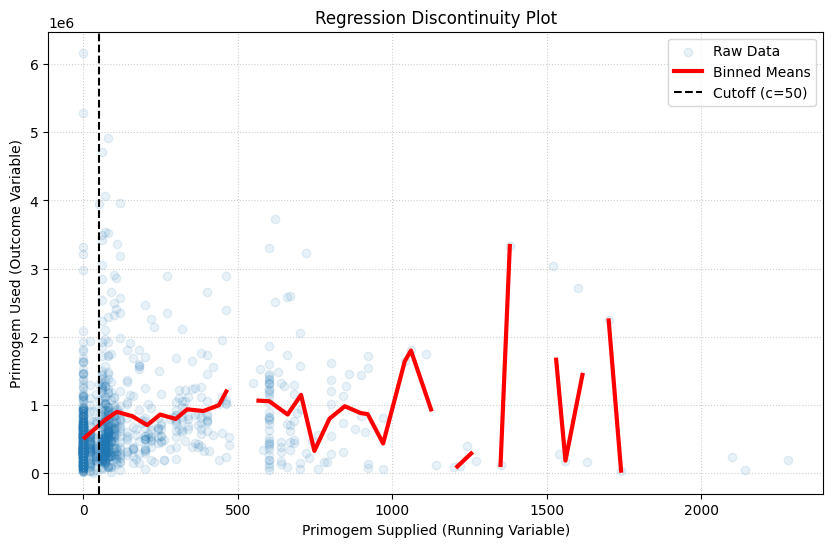

In [16]:
# Create binned means for a clearer view
p_market['bins'] = pd.cut(p_market['Primogem Supplied'], bins=50) # Divide data into 50 bins
binned_data = p_market.groupby('bins', observed=False)[['Primogem Supplied', 'primogem_used']].mean().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
# 1. Scatter plot of the raw data (optional, but shows underlying noise)
plt.scatter(p_market['Primogem Supplied'], p_market['primogem_used'], alpha=0.1, label='Raw Data')
# 2. Plot of binned means (smoother visualization)
plt.plot(binned_data['Primogem Supplied'], binned_data['primogem_used'], color='red', linewidth=3, label='Binned Means')
# 3. Draw the cutoff line
plt.axvline(x=CUTOFF_C, color='black', linestyle='--', label=f'Cutoff (c={CUTOFF_C})')

plt.title('Regression Discontinuity Plot')
plt.xlabel('Primogem Supplied (Running Variable)')
plt.ylabel('Primogem Used (Outcome Variable)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [17]:
p_market

,Unnamed: 0,Date,Total Users,Average Used,Primogem Supplied,primogem_used,centered_supplied,supply_spike,bins
0,0,2022-09-29,400786,8.051699,720.0,3.227008e+06,670.0,1,"(684.0, 729.6]"
1,1,2022-09-30,400786,6.622470,400.0,2.654193e+06,350.0,1,"(364.8, 410.4]"
2,2,2022-10-01,400786,9.301956,620.0,3.728094e+06,570.0,1,"(592.8, 638.4]"
3,3,2022-10-02,400786,4.204556,300.0,1.685127e+06,250.0,1,"(273.6, 319.2]"
4,4,2022-10-03,400786,2.906211,40.0,1.164769e+06,-10.0,0,"(-2.28, 45.6]"
...,...,...,...,...,...,...,...,...,...
1115,1115,2025-10-18,122449,0.965817,0.0,1.182633e+05,-50.0,0,"(-2.28, 45.6]"
1116,1116,2025-10-19,122449,0.927924,0.0,1.136234e+05,-50.0,0,"(-2.28, 45.6]"
1117,1117,2025-10-20,122449,0.796208,0.0,9.749493e+04,-50.0,0,"(-2.28, 45.6]"
1118,1118,2025-10-21,122449,0.316436,1740.0,3.874733e+04,1690.0,1,"(1732.8, 1778.4]"


In [18]:
rdd_formula = (
    'primogem_used ~ supply_spike + centered_supplied + supply_spike:centered_supplied'
)

rdd_model = smf.ols(rdd_formula, data=p_market).fit(cov_type='HC1') 

print("\n--- RDD Model Results: Causal Effect of Supply Spike ---")
print(rdd_model.summary().tables[1]) # Only print the coefficient table
print("-" * 60)


--- RDD Model Results: Causal Effect of Supply Spike ---
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       5.517e+05    1.3e+05      4.229      0.000    2.96e+05    8.07e+05
supply_spike                    2.617e+05   1.36e+05      1.926      0.054   -4642.467    5.28e+05
centered_supplied                404.9054   2792.922      0.145      0.885   -5069.122    5878.933
supply_spike:centered_supplied  -277.3978   2795.466     -0.099      0.921   -5756.410    5201.614
------------------------------------------------------------


In [19]:
# Extract and interpret the key result (LATE)
late_tau = rdd_model.params['supply_spike']
p_value = rdd_model.pvalues['supply_spike']
t_stat = rdd_model.tvalues['supply_spike']

print(f"Key Result: Local Average Treatment Effect (LATE)")
print(f"Cutoff point: {CUTOFF_C}")
print(f"Estimated Jump in Primogem Used at the Cutoff: {late_tau:,.2f}")
print(f"P-value for the jump: {p_value:.4f}")
print(f"T-statistic: {t_stat:.2f}")

if p_value < 0.05:
    print("\n✅ Conclusion: The effect is statistically significant. The supply spike causes a causal increase/decrease (depending on the sign) in Primogem Used by approximately {late_tau:,.2f} at the cutoff.")
else:
    print("\n❌ Conclusion: The effect is NOT statistically significant. We do not find strong evidence of a causal effect from the supply spike.")

Key Result: Local Average Treatment Effect (LATE)
Cutoff point: 50
Estimated Jump in Primogem Used at the Cutoff: 261,658.36
P-value for the jump: 0.0541
T-statistic: 1.93

❌ Conclusion: The effect is NOT statistically significant. We do not find strong evidence of a causal effect from the supply spike.


In [29]:
def run_rdd_at_cutoff(df, cutoff_value):
    """
    Performs the RDD regression for a specified cutoff.
    """
    # Create the centered running variable (X_i - c)
    df['centered_supplied'] = df['Primogem Supplied'] - cutoff_value
    
    # Create the treatment indicator (T_i = 1 if X_i >= c)
    df['supply_spike'] = np.where(df['Primogem Supplied'] >= cutoff_value, 1, 0)
    
    # Define the RDD formula: Y ~ T + (X-c) + T:(X-c)
    rdd_formula = (
        'primogem_used ~ supply_spike + centered_supplied + supply_spike:centered_supplied'
    )
    
    # Check if there are observations on both sides of the cutoff
    if df['supply_spike'].sum() == 0 or df['supply_spike'].sum() == len(df):
        return {
            'LATE': np.nan, 
            'P_Value': np.nan, 
            'Std_Err': np.nan,
            'Obs_Treated': df['supply_spike'].sum()
        }

    # Estimate the model using robust standard errors (HC1)
    try:
        model = smf.ols(rdd_formula, data=df).fit(cov_type='HC1')
        
        # Extract the LATE (coefficient on 'supply_spike')
        late = model.params['supply_spike']
        p_val = model.pvalues['supply_spike']
        std_err = model.bse['supply_spike']
        
        return {
            'LATE': late, 
            'P_Value': p_val, 
            'Std_Err': std_err,
            'Obs_Treated': df['supply_spike'].sum()
        }
    except Exception as e:
        # Handle cases where the regression fails (e.g., perfect collinearity)
        return {
            'LATE': np.nan, 
            'P_Value': np.nan, 
            'Std_Err': np.nan,
            'Obs_Treated': df['supply_spike'].sum()
        }


TEST_CUTOFFS = [1, 20, 75, 100, 600, 700, 1000, 1500, 1600, 1700]
# --- 3. Loop Through Cutoffs and Collect Results ---
results = []
for cutoff in TEST_CUTOFFS:
    # Make a copy of the dataframe to avoid modifying the original in the loop
    temp_df = p_market.copy() 
    
    # Run the RDD
    result_dict = run_rdd_at_cutoff(temp_df, cutoff)
    
    # Store the results with the cutoff value
    result_dict['Cutoff_c'] = cutoff
    results.append(result_dict)


# --- 4. Display Results ---
sensitivity_df = pd.DataFrame(results)

# Create a column for significance
sensitivity_df['Statistically Significant'] = np.where(sensitivity_df['P_Value'] < 0.05, 'YES (p < 0.05)', 'NO')

print("\n--- RDD Cutoff Sensitivity Analysis ---")
print("Analysis of Local Average Treatment Effect (LATE) at various hypothetical cutoffs.")

# Format the output table for readability
sensitivity_df = sensitivity_df.set_index('Cutoff_c')
sensitivity_df[['LATE', 'Std_Err', 'P_Value', 'Obs_Treated']] = sensitivity_df[['LATE', 'Std_Err', 'P_Value', 'Obs_Treated']].round(3)

sensitivity_df[['LATE', 'Std_Err', 'P_Value', 'Statistically Significant', 'Obs_Treated']]




--- RDD Cutoff Sensitivity Analysis ---
Analysis of Local Average Treatment Effect (LATE) at various hypothetical cutoffs.


,LATE,Std_Err,P_Value,Statistically Significant,Obs_Treated
Cutoff_c,,,,,
1,6.368725e+16,8.098682e+16,0.432,NO,697
20,3.755489e+05,1.757270e+04,0.000,YES (p < 0.05),697
75,5.843804e+04,8.021428e+04,0.466,NO,457
100,4.832432e+04,8.193417e+04,0.555,NO,361
600,-3.121585e+05,1.258263e+05,0.013,YES (p < 0.05),114
700,-2.509838e+05,1.605613e+05,0.118,NO,54
1000,3.200813e+04,3.489199e+05,0.927,NO,20
1500,6.702080e+04,5.904390e+05,0.910,NO,10
1600,4.167336e+04,6.710759e+05,0.950,NO,7
